In [1]:
### import libraries
import os
import cv2 as cv2
import numpy as np
import json  as json
import imutils
import math
from matplotlib import pyplot as plt

path_dataset = './dataset/bilboards/'

def iread(img_path, resize_width=None):
    img = cv2.imread(path_dataset + img_path)
    if resize_width is not None:
        img = imutils.resize(img, width=resize_width)
    return img

def iinfo(img):
    print("[IMAGE] height: {} x width: {} x channels: {} - data type: {}".format(
        img.shape[0], 
        img.shape[1], 
        (img.shape[2] if img.ndim > 2 else 0),
        img.dtype))

## Preface - Hough Extended Transform 

We start performing Hough Extended Transform in a bilboard frame.
This frame is quite interesting because it shows the electrical wires deformed by the radial distortions.

The **electrical wires** may be assumed as **lines** representation on the radial distorted space. 

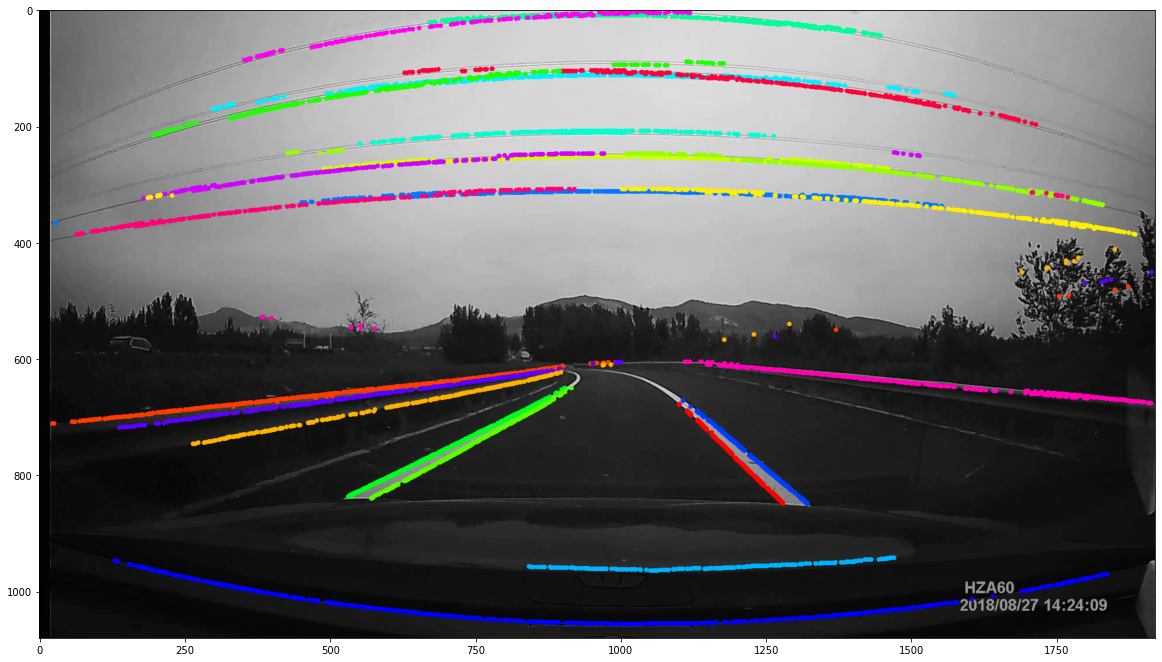

In [2]:
nemesis = iread('dataset_IMG_0249_18.png')
plt.figure(figsize = (20,20))
plt.imshow(nemesis)

### Starting Point - Edges 

We start from the edges points extracted by the Hough Extended transform, just to be sure that both we are working in the same points

[IMAGE] height: 1080 x width: 1920 x channels: 0 - data type: uint8


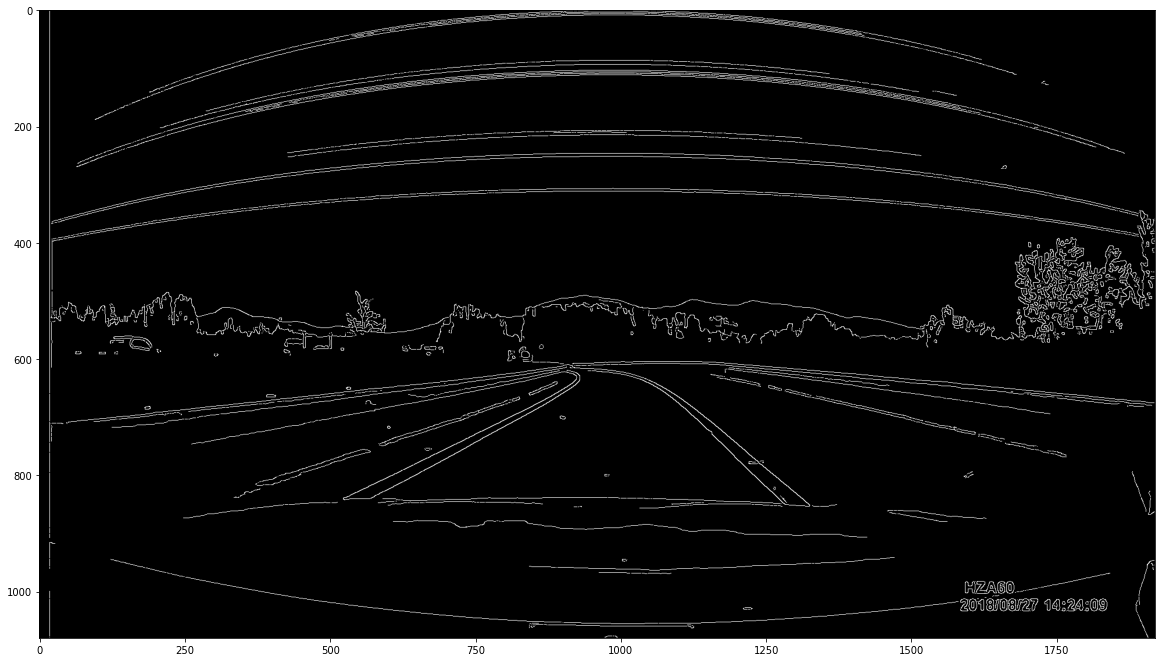

In [3]:
edges_rgb   = iread('dataset_IMG_0249_18_canny.png')
edges_white = cv2.cvtColor(edges_rgb, cv2.COLOR_BGR2GRAY)
edges = cv2.bitwise_not(edges_white)

plt.figure(figsize=(20,20))
plt.imshow(edges, cmap='gray')
iinfo(edges)

### Extract The Roi

From the eges we extract the roi usefull for the preference trick

[IMAGE] height: 420 x width: 1920 x channels: 0 - data type: uint8


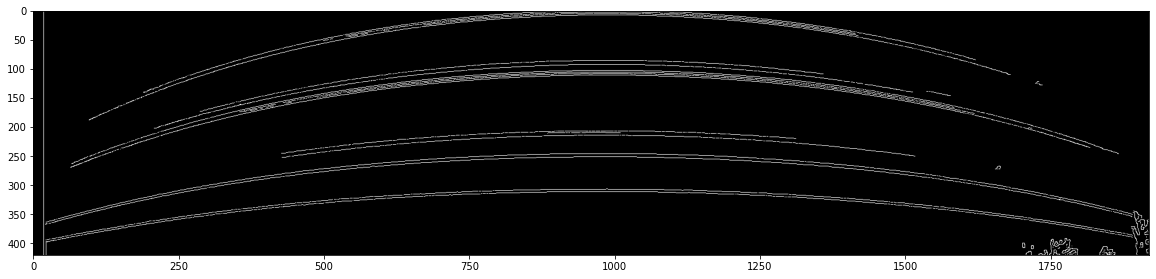

In [4]:
roi=edges[0:420, 0:]
plt.figure(figsize=(20, 20))
plt.imshow(roi, cmap='gray')
iinfo(roi)

### Clustering comparing KMeans vs DBScan

From the roi extracted now we perform two different clustering algorithm, KMeans and Dbscan.
We perform this task because we want dimonstrate that with data effected by radial distortion a Soft Clustering is prefered.

In [5]:
from sklearn.cluster import DBSCAN, KMeans

In [6]:
# some numpy tricks
row, col = roi.nonzero()
pts = np.column_stack((col, row)) # this are the points


Text(0.5, 1.0, 'DBSCAN')

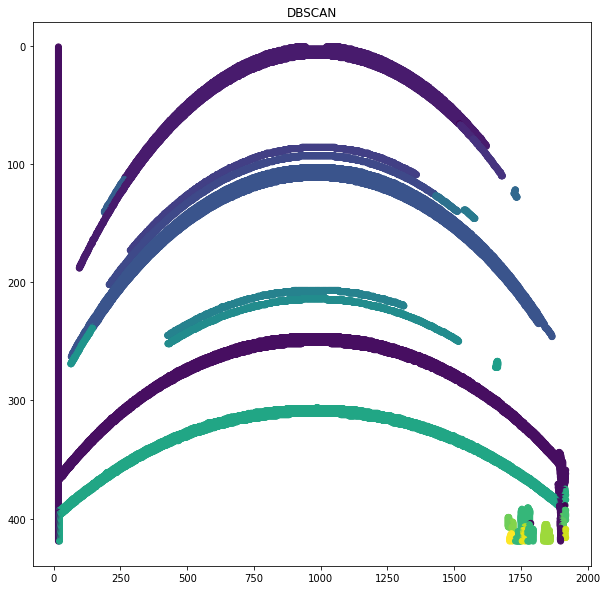

In [7]:
db = DBSCAN(eps=3.5, min_samples=4).fit(pts)
plt.figure(figsize=(10, 10))
plt.gca().invert_yaxis()
plt.scatter(pts[:, 0], pts[:, 1], c=db.fit_predict(pts))
plt.title('DBSCAN')

Text(0.5, 1.0, 'KMeans')

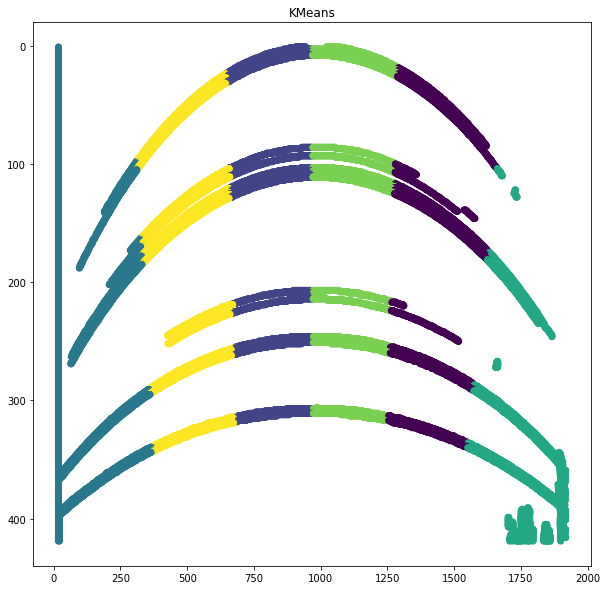

In [8]:
y_pred = KMeans(n_clusters=6, random_state=10000).fit_predict(pts)
plt.figure(figsize=(10, 10))
plt.gca().invert_yaxis()
plt.scatter(pts[:, 0], pts[:, 1], c=y_pred)
plt.title('KMeans')

### Methods

1. Use Clusters obtained by dbscan as column of the preference matrix
2. Order Points by cluster and compute the preference matrix 

In [9]:
pts_clusters=db.fit_predict(pts)

In [10]:
num_clusters   = np.unique(pts_clusters).shape[0]
clusters_label = np.unique(pts_clusters)
print("num_clusters:\t {}\ncluster labels:\n {}".format(num_clusters, clusters_label))


num_clusters:	 28
cluster labels:
 [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26]


In [11]:
from scipy.spatial import distance


In [12]:
def get_cluster_pts(cluster_label):
    return np.where(pts_clusters == cluster_label)[0]

In [13]:
a = get_cluster_pts(18)
b = get_cluster_pts(9)

print("cluster 18] num of pts: {}".format(a.shape[0]))
print("cluster  9] num of pts: {}".format(b.shape[0]))

cluster 18] num of pts: 20
cluster  9] num of pts: 83


In [14]:
# get all cluster
clusters = {}
for l in clusters_label:
    clusters.update({l: get_cluster_pts(l)})


In [15]:
def print_cluster(cluster_pts, color="b"):
    coords = np.take(pts, cluster_pts, axis=0)
    plt.figure(figsize=(10, 10))
    plt.xlim(0, 1920)
    plt.ylim(420, 0)
    plt.scatter(coords[:, 0], coords[:, 1], 1, c=color)

In [16]:
def info_cluster(cluster_label, cluster_pts):
    print("cluster {}] num of points:\t{}".format(cluster_label, cluster_pts.shape[0]))

In [17]:
for k, v in clusters.items():
    info_cluster(k, v)

cluster -1] num of points:	3
cluster 0] num of points:	4355
cluster 1] num of points:	4222
cluster 2] num of points:	40
cluster 3] num of points:	117
cluster 4] num of points:	1001
cluster 5] num of points:	1182
cluster 6] num of points:	5614
cluster 7] num of points:	80
cluster 8] num of points:	19
cluster 9] num of points:	83
cluster 10] num of points:	41
cluster 11] num of points:	936
cluster 12] num of points:	1039
cluster 13] num of points:	96
cluster 14] num of points:	21
cluster 15] num of points:	3596
cluster 16] num of points:	21
cluster 17] num of points:	285
cluster 18] num of points:	20
cluster 19] num of points:	26
cluster 20] num of points:	24
cluster 21] num of points:	19
cluster 22] num of points:	96
cluster 23] num of points:	5
cluster 24] num of points:	12
cluster 25] num of points:	29
cluster 26] num of points:	21


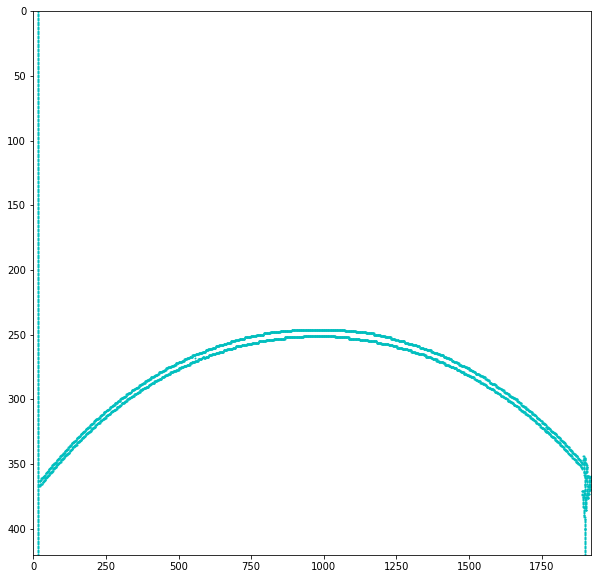

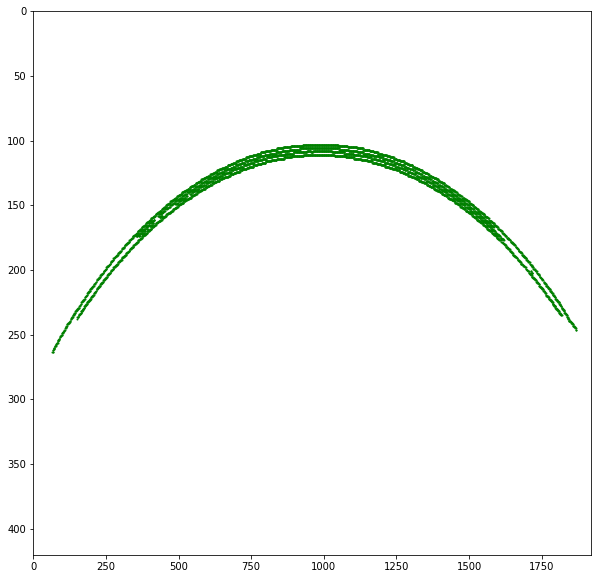

In [18]:
a = get_cluster_pts(0)
b = get_cluster_pts(6)

print_cluster(a, "c")
print_cluster(b, "g")

In [19]:
# get mask
def get_mask(cluster_pts):
    num_pts = pts.shape[0]
    mask = np.zeros(num_pts, dtype=int)
    mask[cluster_pts] = 1
    return mask

In [20]:
m_a = get_mask(a)
m_b = get_mask(b)

In [21]:
distance.jaccard(m_a, m_b)

1.0

In [22]:
def belong_cluster(pt=pt, cluster):
    return 1 if pt in cluster else 0

SyntaxError: non-default argument follows default argument (1173536811.py, line 1)

In [23]:
matrix = np.zeros(shape=(pts.shape[0], len(clusters.items())), dtype=int)
for k, v in clusters.items():
    matrix[v, k+1] = 1
print(clusters.get(0))

[    0    86   132 ... 22974 22975 23002]


In [69]:
def get_preference_matrix(pts, clusters, debug=False):
    matrix = np.zeros(shape=(pts.shape[0], len(clusters.items())), dtype=int)
    for k, v in clusters.items():
        matrix[v, k+1] = 1
    if debug:
        
        import seaborn as sn
        fig, ax = plt.subplots(figsize=(10,10))         
        sn.heatmap(matrix, cmap="YlGnBu", yticklabels=False)
    return matrix

In [25]:
pref_matrix = get_preference_matrix(pts, clusters)

<AxesSubplot:>

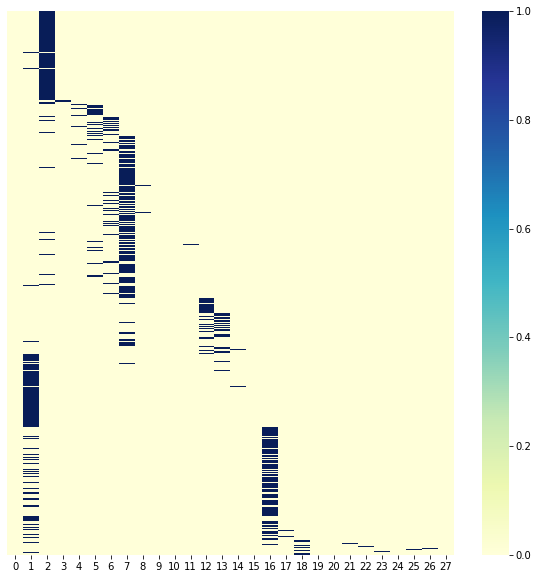

In [26]:
import seaborn as sn
fig, ax = plt.subplots(figsize=(10,10))         
sn.heatmap(pref_matrix, cmap="YlGnBu", yticklabels=False)

In [27]:
### polynomial fitting
test_cluster = get_cluster_pts(6)
coords = np.take(pts, test_cluster, axis=0)


In [28]:
from numpy.polynomial import Chebyshev as T
from numpy.polynomial.chebyshev import chebfit

In [29]:

x = coords[:, 0]
y = coords[:, 1]
c = T.fit(x, y, deg=2, full=False)

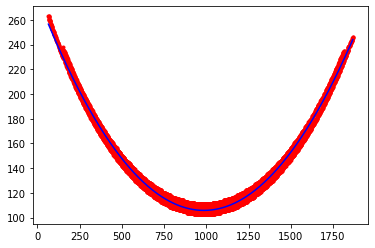

In [30]:
# plot
xs = np.linspace(min(x), max(x), max(x))

plt.plot(x, y, 'r.')
plt.plot(xs, c(xs), 'b')
plt.show()

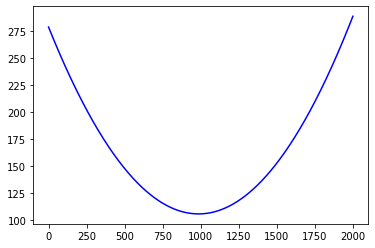

In [31]:
xs = np.linspace(0, 2000, 2000)
plt.plot(xs, c(xs), 'b')
plt.show()

In [32]:
from scipy.spatial import distance

In [33]:
distance.sqeuclidean((0,0), (2000, 275))

4075625.0

In [34]:
x = coords[:, 0]
y = coords[:, 1]
c, [resid, rank, sv, rcond] = T.fit(x, y, deg=2, full=True)


In [35]:
resid

array([61719.01407105])

In [36]:
rank

3

In [37]:
print(np.nonzero(x==1000))
print(c(1000))
print(y[72])


(array([  72,  357,  640, 1125]),)
105.889394147804
103


In [38]:
# evaluate the approximation
i = 0
errors = []
for xs in x:
    point  = xs
    data   = y[i]
    approx = c(xs)
    err    = np.abs(approx - data)
    print("{}] evaluate point {}: data {} approx {} error {}".format(i, point, data, approx, err))
    i += 1
    errors.append(err)
    
print ('residuals: data {} - chebyshev {}'.format(np.sum(errors), resid))
errors = np.array(errors)

0] evaluate point 928: data 103 approx 106.45262439014564 error 3.452624390145644
1] evaluate point 929: data 103 approx 106.43215730283681 error 3.4321573028368135
2] evaluate point 930: data 103 approx 106.41204639707883 error 3.412046397078825
3] evaluate point 931: data 103 approx 106.39229167287164 error 3.392291672871636
4] evaluate point 932: data 103 approx 106.37289313021527 error 3.3728931302152745
5] evaluate point 933: data 103 approx 106.35385076910974 error 3.353850769109741
6] evaluate point 934: data 103 approx 106.335164589555 error 3.3351645895550064
7] evaluate point 935: data 103 approx 106.31683459155111 error 3.316834591551114
8] evaluate point 936: data 103 approx 106.29886077509802 error 3.298860775098021
9] evaluate point 937: data 103 approx 106.28124314019576 error 3.2812431401957554
10] evaluate point 938: data 103 approx 106.2639816868443 error 3.2639816868443035
11] evaluate point 939: data 103 approx 106.24707641504368 error 3.2470764150436793
12] evaluat

994] evaluate point 1193: data 110 approx 113.48807690095617 error 3.488076900956173
995] evaluate point 1194: data 110 approx 113.56199792461437 error 3.5619979246143743
996] evaluate point 1195: data 110 approx 113.6362751298234 error 3.636275129823403
997] evaluate point 1196: data 110 approx 113.71090851658325 error 3.7109085165832454
998] evaluate point 1197: data 110 approx 113.78589808489392 error 3.7858980848939154
999] evaluate point 1198: data 110 approx 113.8612438347554 error 3.861243834755399
1000] evaluate point 1199: data 110 approx 113.9369457661677 error 3.936945766167696
1001] evaluate point 1200: data 110 approx 114.01300387913082 error 4.013003879130821
1002] evaluate point 757: data 111 approx 115.19050220629727 error 4.190502206297268
1003] evaluate point 758: data 111 approx 115.10912807379842 error 4.109128073798416
1004] evaluate point 759: data 111 approx 115.02811012285036 error 4.028110122850364
1005] evaluate point 760: data 111 approx 114.94744835345314 er

2652] evaluate point 1359: data 126 approx 130.63687316668432 error 4.636873166684325
2653] evaluate point 1360: data 126 approx 130.76992032777846 error 4.769920327778465
2654] evaluate point 1361: data 126 approx 130.90332367042345 error 4.903323670423447
2655] evaluate point 602: data 127 approx 132.10972769302205 error 5.109727693022052
2656] evaluate point 603: data 127 approx 131.97314542014624 error 4.973145420146238
2657] evaluate point 604: data 127 approx 131.83691932882127 error 4.836919328821267
2658] evaluate point 605: data 127 approx 131.7010494190471 error 4.701049419047109
2659] evaluate point 606: data 127 approx 131.56553569082376 error 4.565535690823765
2660] evaluate point 607: data 127 approx 131.43037814415123 error 4.430378144151234
2661] evaluate point 608: data 127 approx 131.29557677902952 error 4.295576779029517
2662] evaluate point 609: data 127 approx 131.16113159545864 error 4.161131595458642
2663] evaluate point 623: data 127 approx 129.3162980883022 err

4585] evaluate point 359: data 173 approx 175.85857825742065 error 2.858578257420646
4586] evaluate point 360: data 173 approx 175.63544386769584 error 2.635443867695841
4587] evaluate point 361: data 173 approx 175.41266565952185 error 2.412665659521849
4588] evaluate point 362: data 173 approx 175.19024363289867 error 2.190243632898671
4589] evaluate point 363: data 173 approx 174.96817778782633 error 1.9681777878263347
4590] evaluate point 380: data 173 approx 171.24755419887165 error 1.7524458011283457
4591] evaluate point 381: data 173 approx 171.03189962171405 error 1.9681003782859534
4592] evaluate point 382: data 173 approx 170.81660122610725 error 2.1833987738927476
4593] evaluate point 383: data 173 approx 170.60165901205127 error 2.3983409879487283
4594] evaluate point 384: data 173 approx 170.38707297954613 error 2.612927020453867
4595] evaluate point 1586: data 173 approx 169.97499169511485 error 3.025008304885148
4596] evaluate point 1587: data 173 approx 170.188892068244

max: 7.689930157372061 min 0.0010337120075405437 avg 2.861316337004747


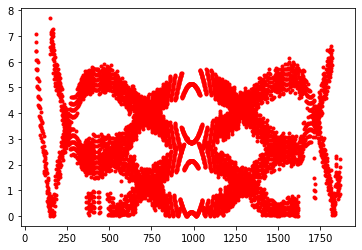

In [39]:
print("max: {} min {} avg {}".format(errors.max(), errors.min(), errors.mean()))

plt.plot(x, errors, 'r.')
plt.show()


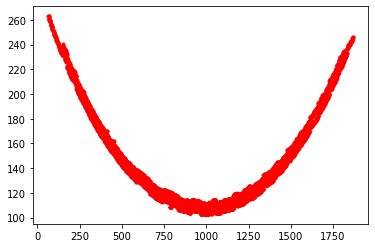

In [51]:
thr = 2.86

to_eliminate = errors.copy()
to_eliminate[to_eliminate >= thr] = 0


plt.plot(x, to_eliminate[x] + y, 'r.')
plt.show()


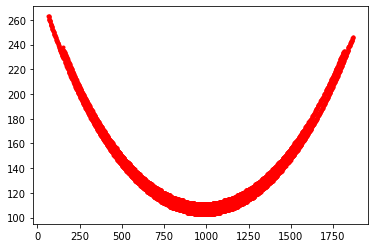

In [42]:
plt.plot(x, y, 'r.')
plt.show()

(5614,)
(5614,)


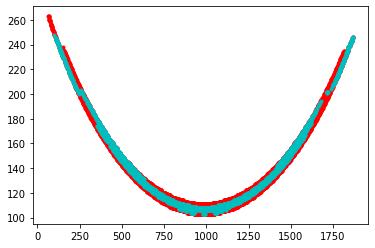

In [59]:
print(y.shape)
print(to_eliminate.shape)
xs_new = x.copy()
ys_new = y.copy()
for i in range(to_eliminate.shape[0]):
    if to_eliminate[i] == 0.:
        ys_new[i] = 0
        xs_new[i] = 0

xs_new = xs_new[xs_new>0]
ys_new = ys_new[ys_new>0]
plt.plot(x, y, 'r.')
plt.plot(xs_new, ys_new, 'c.')
plt.show()

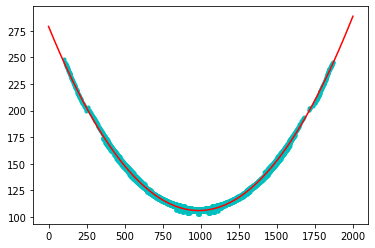

In [60]:
# new parabola
c_2, [resid, rank, sv, rcond] = T.fit(xs_new, ys_new, deg=2, full=True)

x_axis = np.linspace(0, 2000, 2000)
plt.plot(xs_new, ys_new, 'c.')
plt.plot(x_axis, c_2(x_axis), 'r')
plt.show()


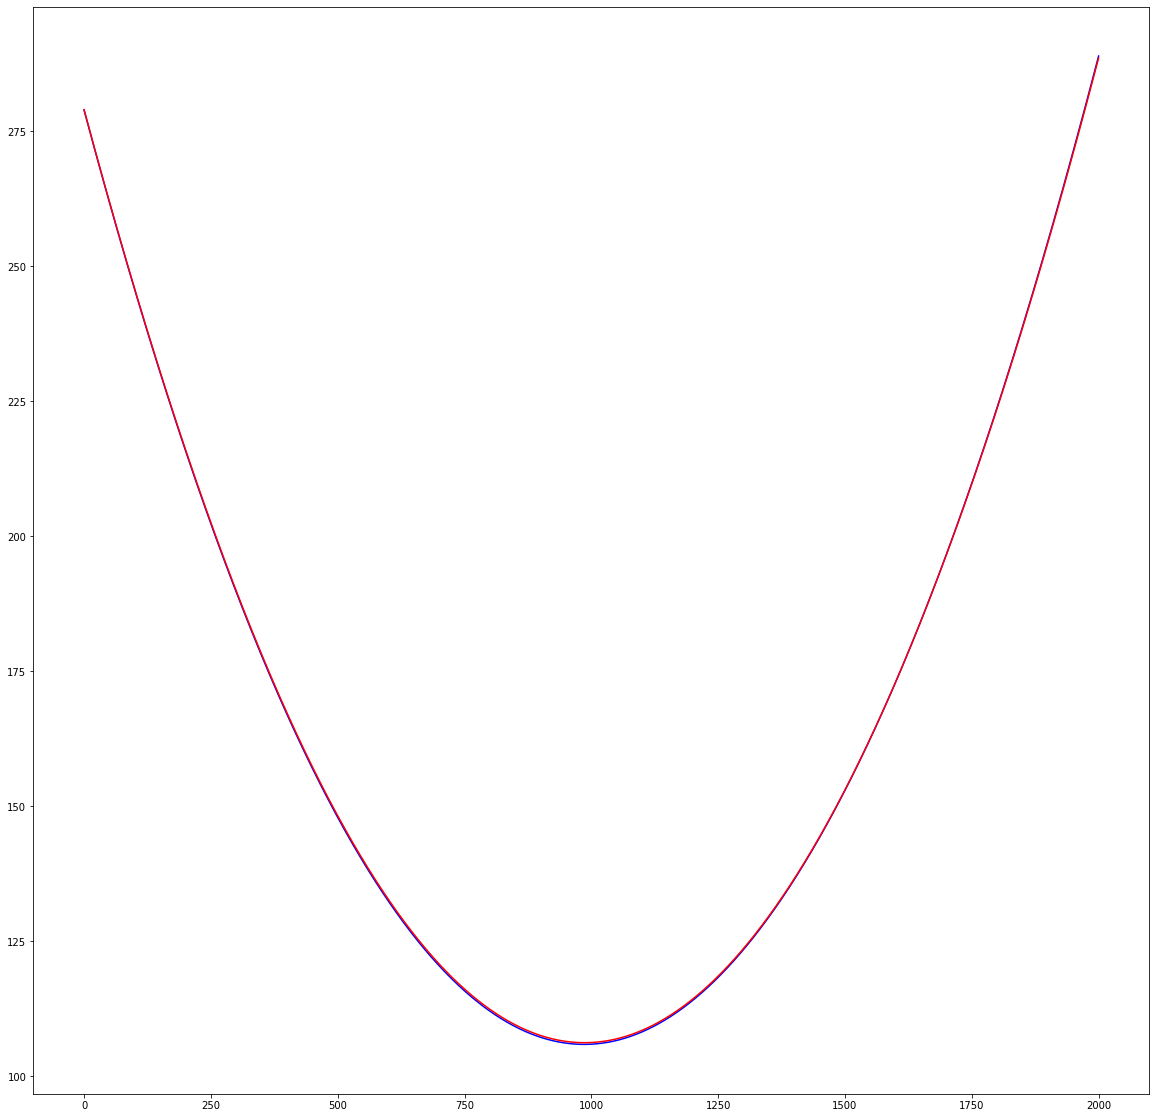

In [66]:
x_axis = np.linspace(0, 2000, 2000)
fig, ax = plt.subplots(figsize=(20,20)) 
plt.plot(x_axis, c(x_axis), 'b')
plt.plot(x_axis, c_2(x_axis), 'r')
plt.show()

In [62]:
c_2

Chebyshev([175.4180605 ,  -0.79552544,  69.24906909], domain=[ 101., 1867.], window=[-1.,  1.])

In [63]:
c

Chebyshev([178.12868724,  -6.24243563,  72.20692715], domain=[  66., 1867.], window=[-1.,  1.])

In [167]:
def cut_threshold(x, y, errors, thr):
    
    xs_new = x.copy()
    ys_new = y.copy()
    
    to_eliminate = errors.copy()
    to_eliminate[to_eliminate >= thr] = 0

    for i in range(to_eliminate.shape[0]):
        if to_eliminate[i] == 0:
            ys_new[i] = 0
            xs_new[i] = 0

    xs_new = xs_new[xs_new>0]
    ys_new = ys_new[ys_new>0]
    return xs_new, ys_new
    
    
def evaluate(x, y, c):
    # evaluate the approximation
    i = 0
    errors = []
    for x_ in x:
        point  = x_
        data   = y[i]
        approx = c(x_)
        err    = np.abs(approx - data)
        #print("{}] evaluate point {}: data {} approx {} error {}".format(i, point, data, approx, err))
        i += 1
        errors.append(err)
    
    print ('residuals: data {} - chebyshev {}'.format(np.sum(errors), resid))
    errors = np.array(errors)
    return errors


def clean_pts(pts):
    x = pts[:, 0]
    y = pts[:, 1]
    c = T.fit(x, y, deg=2, full=False)
    x_axis = np.linspace(0, x.max(), x.max())
    
    plt.figure()
    plt.plot(x, y, 'r.')
    plt.plot(x_axis, c(x_axis), 'b')
    plt.show()

    errors = evaluate(x, y, c)
    print("max: {} min {} avg {}".format(errors.max(), errors.min(), errors.mean()))
    xs_new, ys_new = cut_threshold(x, y, errors, errors.mean() + np.abs(errors.mean()-errors.max())*0.25)
    print("approx x: {} -> {} approx y: {} -> {}".format(x.shape[0], xs_new.shape[0], y.shape[0], ys_new.shape[0]))
    
    # recalculate approx
    c_new = T.fit(xs_new, ys_new, deg=2, full=False)
    plt.figure()
    plt.plot(xs_new, ys_new, 'c.')
    plt.plot(x_axis, c_new(x_axis), 'b')
    plt.show()
    
    # compare
    x_axis = np.linspace(0, 2000, 2000)
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,20)) 
    plt.plot(x_axis, c(x_axis), 'b')
    plt.plot(x_axis, c_new(x_axis), 'r')
    plt.show()
    

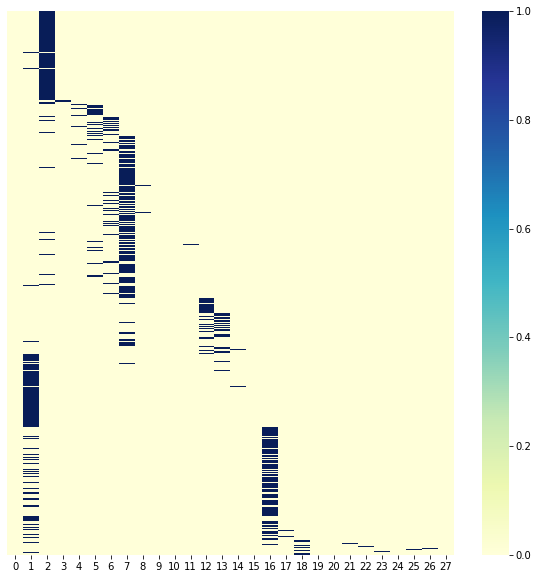

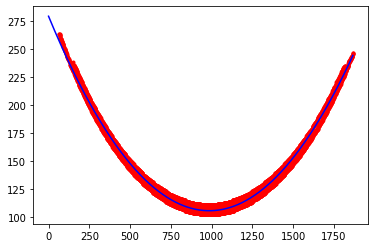

residuals: data 16063.429915944651 - chebyshev [8257.66532247]
max: 7.689930157372061 min 0.0010337120075405437 avg 2.861316337004747
approx x: 5614 -> 3993 approx y: 5614 -> 3993


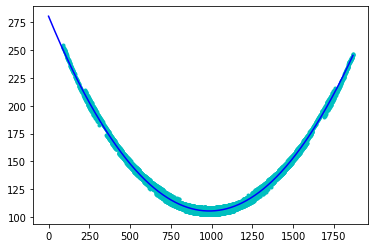

<Figure size 432x288 with 0 Axes>

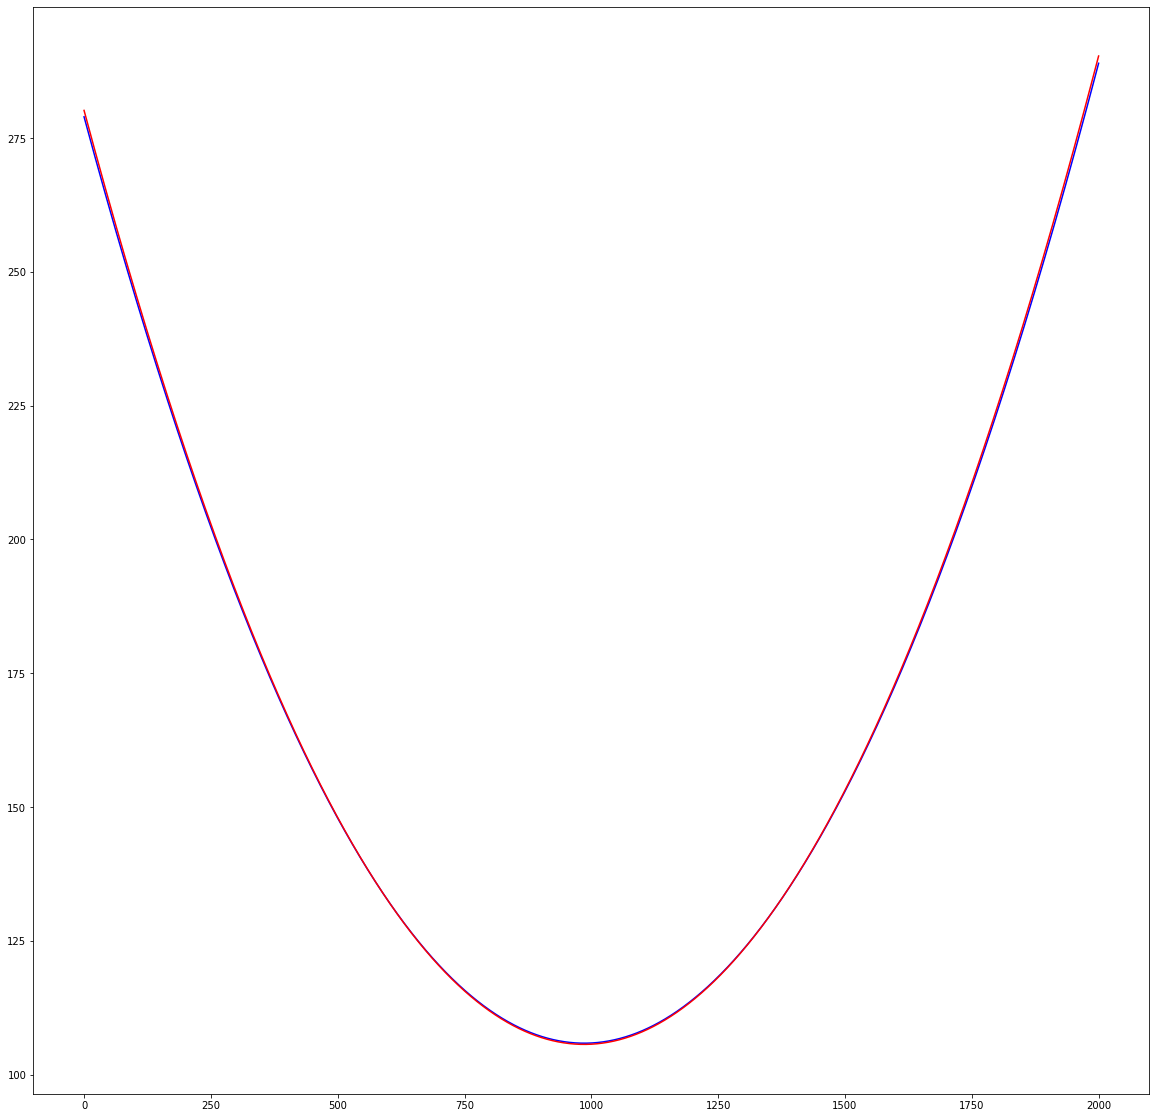

In [168]:
# lets choose a cluster
pref_matrix = get_preference_matrix(pts, clusters, debug=True)
test_cluster = get_cluster_pts(6)
coords = np.take(pts, test_cluster, axis=0)

clean_pts(coords)

[[ 279  270]
 [1009   49]
 [1001   76]
 [1614  187]
 [1317  291]
 [ 920   60]
 [1469  356]
 [1904  286]
 [ 692  286]
 [1488  217]
 [ 706  287]
 [ 612  151]
 [  98  236]
 [ 951  365]
 [1645  375]
 [ 341  158]
 [ 656  201]
 [1434  398]
 [ 278  209]
 [ 562  367]
 [1294  225]
 [ 966  367]
 [ 978  119]
 [ 952  217]
 [ 153  214]
 [ 416  330]
 [  58  364]
 [  66  154]
 [ 304  314]
 [1777  234]
 [ 443  276]
 [ 551  377]
 [1382  283]
 [ 829  100]
 [ 495  158]
 [1773   29]
 [ 653    1]
 [1480   30]
 [1279  375]
 [ 951  170]
 [ 781   72]
 [ 426  102]
 [1563  269]
 [1238  147]
 [ 349  113]
 [  68  209]
 [1075  139]
 [ 113   30]
 [1582   44]
 [ 454  415]
 [ 695  418]
 [1287   76]
 [1346   82]
 [ 613  238]
 [1070  365]
 [ 883  237]
 [1159  281]
 [1845  352]
 [ 655  143]
 [ 492  320]
 [1012  381]
 [ 347   76]
 [1068  320]
 [1907  103]
 [ 250  188]
 [ 441  363]
 [1118  278]
 [ 471    5]
 [ 403  356]
 [ 851  393]
 [1052  345]
 [1155  217]
 [1121   24]
 [ 160  157]
 [ 476  180]
 [1650  218]
 [ 633  305]

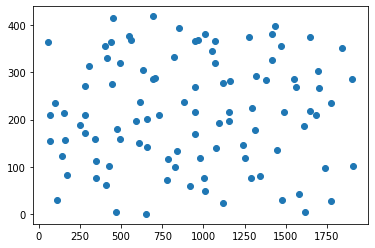

In [126]:
# with random noise
qty_noise = 100
noise = np.random.randint(low=(0, 0), high=(roi.shape[1], roi.shape[0]), size=(qty_noise, 2))
print(noise)
noise_x = noise[:, 0]
noise_y = noise[:, 1]

plt.scatter(noise_x, noise_y)

In [135]:
ex = np.zeros(shape=(100, 2), dtype=int)
print (ex)
asd = np.concatenate([ex, noise])
print(asd)

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
[[   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]


In [175]:
def get_random(pts, qty_noise=2000):
    noise = np.random.randint(low=(0, 0), high=(roi.shape[1], roi.shape[0]), size=(qty_noise, 2))
    print("num of pts {}, num of noise {}".format(pts.shape[0], noise.shape[0]))
    noise_x = noise[:, 0]
    noise_y = noise[:, 1]

    plt.figure()
    plt.scatter(noise_x, noise_y)
    return noise

def add_random(pts, noise):
    pts_new = pts.copy()
    return np.concatenate([pts_new, noise])

def clean_pts_with_random(pts):
    # add random
    noise = get_random(pts)
    pts = add_random(pts, noise) 
    
    x = pts[:, 0]
    y = pts[:, 1]
    c = T.fit(x, y, deg=2, full=False)
    x_axis = np.linspace(0, x.max(), x.max())
    
    plt.figure()
    plt.plot(x, y, 'r.')
    plt.plot(x_axis, c(x_axis), 'b')
    plt.show()

    errors = evaluate(x, y, c)
    print("max: {} min {} avg {}".format(errors.max(), errors.min(), errors.mean()))
    xs_new, ys_new = cut_threshold(x, y, errors, errors.mean() + np.abs(errors.mean()-errors.max())*0.05)
    print("approx x: {} -> {} approx y: {} -> {}".format(x.shape[0], xs_new.shape[0], y.shape[0], ys_new.shape[0]))
    
    # recalculate approx
    c_new = T.fit(xs_new, ys_new, deg=2, full=False)
    plt.figure()
    plt.plot(xs_new, ys_new, 'c.')
    plt.plot(x_axis, c_new(x_axis), 'b')
    plt.show()

    plt.figure()
    x_axis = np.linspace(0, 2000, 2000)
    fig, ax = plt.subplots(figsize=(20,20)) 
    plt.plot(x_axis, c(x_axis), 'b')
    plt.plot(x_axis, c_new(x_axis), 'r')
    plt.show()

num of pts 5614, num of noise 2000


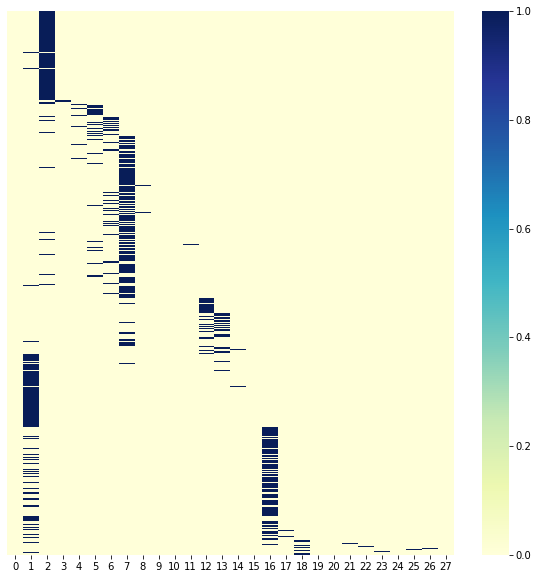

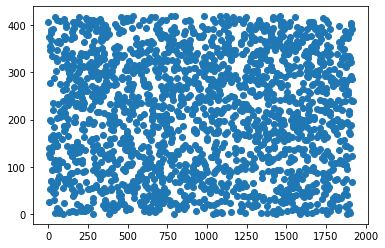

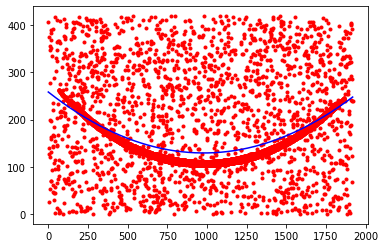

residuals: data 317236.1612194426 - chebyshev [8257.66532247]
max: 289.7911269202366 min 0.00886644145310811 avg 41.66484912259556
approx x: 7614 -> 6109 approx y: 7614 -> 6109


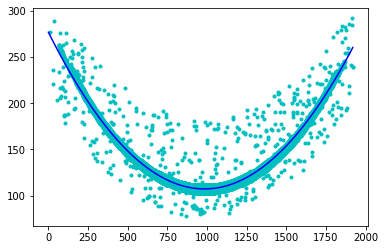

<Figure size 432x288 with 0 Axes>

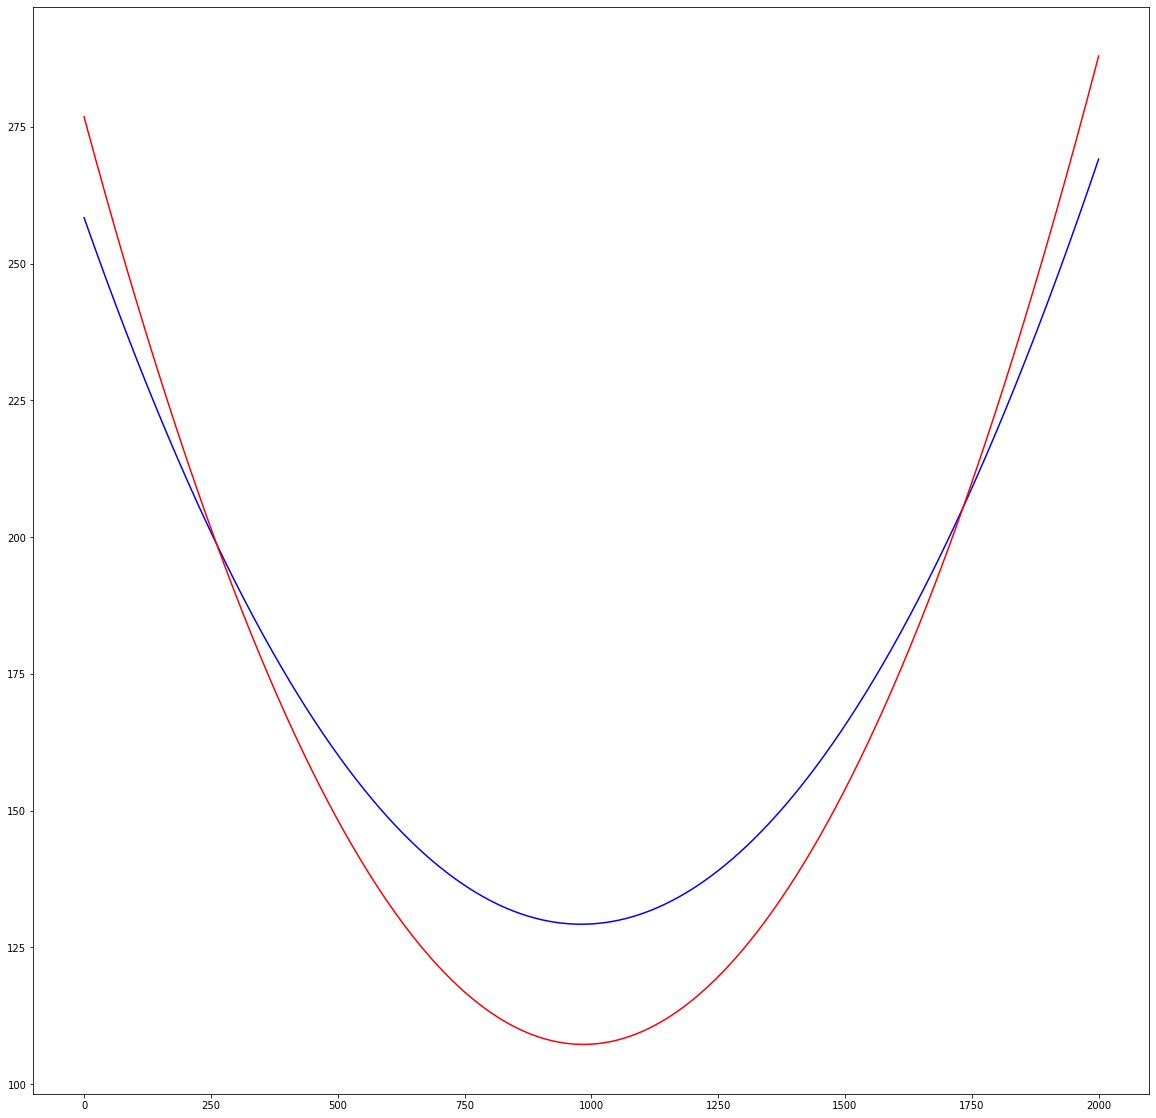

In [176]:
# lets choose a cluster
pref_matrix = get_preference_matrix(pts, clusters, debug=True)
test_cluster = get_cluster_pts(6)
coords = np.take(pts, test_cluster, axis=0)

clean_pts_with_random(coords)

In [ ]:
get_random(np.zeros(shape=(2, 100)))

In [159]:
pts

array([[  18,    1],
       [ 907,    1],
       [ 908,    1],
       ...,
       [1859,  419],
       [1860,  419],
       [1899,  419]])

### Noise in clustering

num of points (23003, 2)
num of pts 23003, num of noise 5751
num of points with random 28754


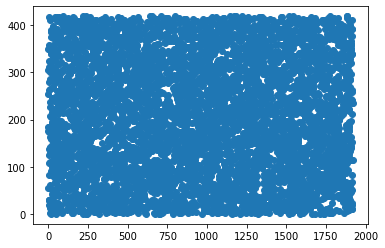

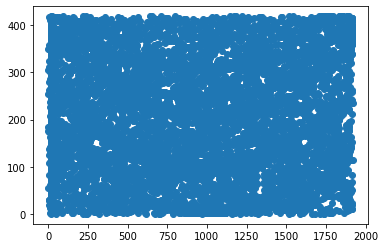

In [189]:
row, col = roi.nonzero()
or_pts = np.column_stack((col, row)) # this are the points

print ("num of points {}".format(or_pts.shape))

# add + 25% random
noise = get_random(or_pts, round(or_pts.shape[0] * 0.25))
pts = add_random(or_pts, noise)
print ("num of points with random {}".format(pts.shape[0]))
plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])

Text(0.5, 1.0, 'DBSCAN')

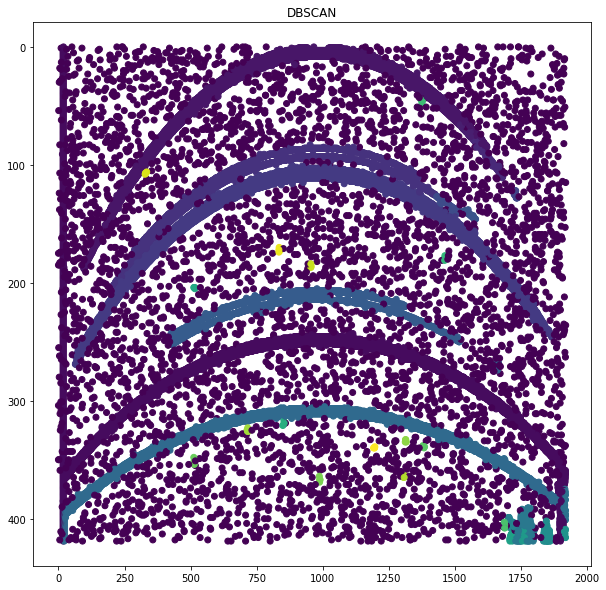

In [190]:
db = DBSCAN(eps=3.5, min_samples=4).fit(pts)
plt.figure(figsize=(10, 10))
plt.gca().invert_yaxis()
plt.scatter(pts[:, 0], pts[:, 1], c=db.fit_predict(pts))
plt.title('DBSCAN')

In [193]:
pts_clusters=db.fit_predict(pts)
num_clusters   = np.unique(pts_clusters).shape[0]
clusters_label = np.unique(pts_clusters)
print("num_clusters:\t {}\ncluster labels:\n {}".format(num_clusters, clusters_label))

# get all cluster
clusters = {}
for l in clusters_label:
    clusters.update({l: get_cluster_pts(l)})


num_clusters:	 36
cluster labels:
 [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34]


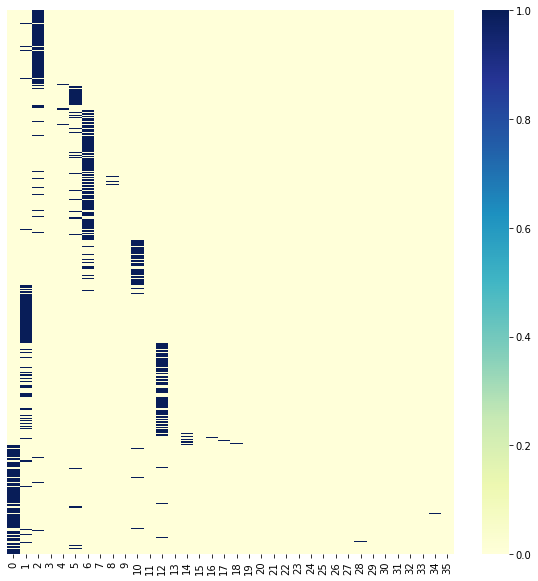

In [194]:
# lets choose a cluster
pref_matrix = get_preference_matrix(pts, clusters, debug=True)
